In [273]:
# python ######################################################################
import sys
import os
import datetime

# basics ######################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# widgets #####################################################################
import ipywidgets as widgets
from ipywidgets import interact

# process mining ##############################################################
import pm4py

# object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# algo.filtering
from pm4py.algo.filtering.log.auto_filter.auto_filter import apply_auto_filter

# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
# vizualization
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# statistics
from pm4py.statistics.traces.log import case_statistics

# util
from pm4py.util import vis_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
clicks_logged_in_SelectedColumns = pd.read_csv('clicks_logged_in_SelectedColumns.csv')
clicks_logged_in_SelectedColumns.head()

,CustomerID,SessionID,AgeCategory,Gender,TIMESTAMP,PAGE_NAME
0,2025826,12956475,50-65,V,2015-10-05 10:12:56.880,50plus
1,2025826,13243433,50-65,V,2015-09-30 15:14:35.943,50plus
2,1503890,14805466,30-39,V,2015-09-01 19:35:06.707,aanvragen-tw
3,2063574,12710639,50-65,M,2015-11-06 10:47:42.137,50plus
4,2185161,44281847,18-29,V,2016-01-11 18:44:07.877,bijstandsuitkering


In [3]:
clicks_logged_in_SelectedColumns.sort_values(['CustomerID', 'SessionID'], ascending=[True, True])

,CustomerID,SessionID,AgeCategory,Gender,TIMESTAMP,PAGE_NAME
522312,220,37784474,40-49,V,2015-12-07 10:12:33.923,mijn_berichten
525993,220,37784474,40-49,V,2015-12-07 10:12:51.353,mijn_cv
526001,220,37784474,40-49,V,2015-12-07 10:14:11.293,mijn_cv
526947,220,37784474,40-49,V,2015-12-07 10:14:49.287,mijn_cv
526953,220,37784474,40-49,V,2015-12-07 10:14:54.077,mijn_cv
...,...,...,...,...,...,...
4328687,2240448,54997653,18-29,V,2016-02-28 13:27:33.703,taken
4698173,2240448,54997653,18-29,V,2016-02-28 13:27:59.707,taken
4698544,2240448,54997653,18-29,V,2016-02-28 13:28:21.290,taken
4699334,2240448,54997653,18-29,V,2016-02-28 13:27:53.247,taken


In [4]:
number_of_sessions_per_customer = pd.DataFrame(clicks_logged_in_SelectedColumns.groupby('CustomerID')['SessionID'].nunique())
number_of_sessions_per_customer.reset_index(level=0, inplace=True)
number_of_sessions_per_customer = number_of_sessions_per_customer.rename(columns={'index': 'CustomerID','SessionID': '# of Sessions' })
number_of_sessions_per_customer.head(10)

,CustomerID,# of Sessions
0,220,19
1,318,11
2,495,15
3,511,29
4,609,31
5,1055,3
6,1339,14
7,1362,34
8,1445,16
9,1453,40


In [5]:
number_of_sessions_per_customer.sort_values(['# of Sessions'], ascending=True)

,CustomerID,# of Sessions
842,90834,1
11169,1692568,1
11166,1691597,1
24646,2200449,1
11154,1689670,1
...,...,...
15111,2033620,364
15303,2036141,423
6236,984160,433
9128,1389451,450


In [6]:
Segments_Comparison = {'Session': ['1 Session' ,'2 Session'],
                     'Customers': [] ,
                     'Change': [] ,
                     
                    }
Segments_Comparison

{'Session': ['1 Session', '2 Session'], 'Customers': [], 'Change': []}

In [7]:
number_of_customer_min_sessions = list()

for one in range(1,16):
    number_of_customer_min_sessions.append(
        number_of_sessions_per_customer[number_of_sessions_per_customer['# of Sessions'] >= one]['CustomerID'].count())
    
number_of_customer_min_sessions

[26647,
 25705,
 24733,
 23815,
 22901,
 21959,
 21059,
 20151,
 19298,
 18462,
 17699,
 16970,
 16209,
 15444,
 14800]

In [8]:
session_list = ['1 Session']

for one in range(2,16):
    session_list.append(str(one) +' ' + "Sessions")
    
session_list

['1 Session',
 '2 Sessions',
 '3 Sessions',
 '4 Sessions',
 '5 Sessions',
 '6 Sessions',
 '7 Sessions',
 '8 Sessions',
 '9 Sessions',
 '10 Sessions',
 '11 Sessions',
 '12 Sessions',
 '13 Sessions',
 '14 Sessions',
 '15 Sessions']

In [9]:
change_list = ['-']

for one in range(1,15):
    change_list.append(round((number_of_customer_min_sessions[one]-number_of_customer_min_sessions[one-1])/number_of_customer_min_sessions[one-1]*100,2))
    
change_list

['-',
 -3.54,
 -3.78,
 -3.71,
 -3.84,
 -4.11,
 -4.1,
 -4.31,
 -4.23,
 -4.33,
 -4.13,
 -4.12,
 -4.48,
 -4.72,
 -4.17]

In [10]:
least_one_session = pd.DataFrame(
    {'Session': session_list,
     'Customers': number_of_customer_min_sessions,
     'Change': change_list
    })

least_one_session = pd.DataFrame(data=least_one_session)
least_one_session


,Session,Customers,Change
0,1 Session,26647,-
1,2 Sessions,25705,-3.54
2,3 Sessions,24733,-3.78
3,4 Sessions,23815,-3.71
4,5 Sessions,22901,-3.84
5,6 Sessions,21959,-4.11
6,7 Sessions,21059,-4.1
7,8 Sessions,20151,-4.31
8,9 Sessions,19298,-4.23
9,10 Sessions,18462,-4.33



    
    
<center>
    <img src="https://user-images.githubusercontent.com/35700552/151620169-0769f4ce-4889-4e3b-8331-dc0c5e218cc7.png"  />
</center>    

In [29]:
clicks_logged_in_SelectedColumns_SortedbyTime = clicks_logged_in_SelectedColumns.sort_values('TIMESTAMP', ascending=True)

In [30]:
clicks_logged_in_SelectedColumns_SortedbyTime

,CustomerID,SessionID,AgeCategory,Gender,TIMESTAMP,PAGE_NAME
3271608,797444,10125891,50-65,M,2015-07-01 02:36:59.713,mijn_berichten
5687809,797444,10125891,50-65,M,2015-07-01 02:37:13.210,mijn_cv
6113803,797444,10125891,50-65,M,2015-07-01 02:37:21.187,mijn_cv
6167539,797444,10125891,50-65,M,2015-07-01 02:38:42.573,mijn_sollicitaties
6167542,797444,10125891,50-65,M,2015-07-01 02:39:26.053,mijn_sollicitaties
...,...,...,...,...,...,...
5501507,2094324,54459141,50-65,M,2016-02-29 00:59:51.317,mijn_agenda
5501253,2094324,54459141,50-65,M,2016-02-29 00:59:53.490,mijn_agenda
5500906,2094324,54459141,50-65,M,2016-02-29 00:59:55.840,mijn_agenda
5500908,2094324,54459141,50-65,M,2016-02-29 00:59:57.400,mijn_agenda


In [156]:
sessions_per_customer_SortedbyTime = clicks_logged_in_SelectedColumns_SortedbyTime.groupby('CustomerID').apply(lambda x: x['SessionID'].unique())
sessions_per_customer_SortedbyTime

CustomerID
220        [37784474, 38388239, 40228720, 39094411, 38904...
318        [8036042, 38441945, 38613610, 38392664, 401541...
495        [23245109, 16502166, 1259745, 25487862, 489649...
511        [15779401, 18413107, 24881646, 12676015, 98919...
609        [2286223, 16771094, 8883102, 32590760, 3439449...
                                 ...                        
2240369                       [28246128, 16537487, 51094632]
2240373    [47479462, 47560297, 47469266, 49848969, 49853...
2240374                                           [49945317]
2240435    [40775021, 40426594, 39176154, 44288407, 44881...
2240448                                 [52923129, 54997653]
Length: 26647, dtype: object

In [162]:
sessions_per_customer_SortedbyTime = pd.DataFrame(sessions_per_customer_SortedbyTime)
sessions_per_customer_SortedbyTime_values = sessions_per_customer_SortedbyTime[0].to_list()
sessions_per_customer_SortedbyTime_values

[array([37784474, 38388239, 40228720, 39094411, 38904702, 41369224,
        43113120, 40486889, 46453777, 46837792, 46765348, 47163158,
        50276772, 50517675, 48678702, 48198743, 49036789, 48766889,
        53681407], dtype=int64),
 array([ 8036042, 38441945, 38613610, 38392664, 40154127, 41821798,
        42435925, 40223582, 46220878, 49934500, 49343917], dtype=int64),
 array([23245109, 16502166,  1259745, 25487862,  4896491, 14616657,
         9357465, 28699383, 22325963, 27254425, 21537056, 30646395,
        32981625, 32680615, 35097439], dtype=int64),
 array([15779401, 18413107, 24881646, 12676015,  9891909, 13433166,
         6127709, 10820505, 20361510,  6838093, 23669377, 14243476,
        19290768, 20413099, 14745258, 18716944, 12653694,  1664697,
        35752133, 36775610, 38660664, 38720243, 40143131, 39653748,
        43508377, 41636987, 44176390, 46048175, 52694699], dtype=int64),
 array([ 2286223, 16771094,  8883102, 32590760, 34394498, 35067297,
        35533092, 36

In [163]:
sessions_per_customer_SortedbyTime_values[0][1]

38388239

In [175]:
list_of_session_ones = list()

for one in sessions_per_customer_SortedbyTime_values:
    list_of_session_ones.append(one[0])

In [105]:
list_of_session_ones


[37784474,
 8036042,
 23245109,
 15779401,
 2286223,
 43168418,
 29124528,
 8337326,
 5292512,
 6457990,
 876081,
 46327535,
 14033910,
 5980347,
 992342,
 15100372,
 20616300,
 9099318,
 12619651,
 4905349,
 30725887,
 41622532,
 16687452,
 35236687,
 6230347,
 45044677,
 10784936,
 39496265,
 2580413,
 8916670,
 109188,
 41949323,
 27902779,
 23728185,
 39983517,
 34518289,
 30484273,
 38766800,
 21182684,
 5702402,
 21292376,
 44545811,
 14202615,
 7914440,
 2243299,
 7780789,
 15003564,
 15697255,
 4443278,
 29751214,
 42203675,
 28967702,
 32873484,
 7181301,
 37450875,
 16530195,
 34670473,
 17062680,
 22412688,
 8012099,
 45022598,
 2029745,
 49064675,
 2598879,
 7254518,
 23353563,
 13747512,
 2992663,
 45320303,
 11578039,
 14884216,
 25583785,
 45264178,
 40965345,
 5117016,
 26119802,
 6509304,
 35976570,
 40148415,
 127043,
 11808560,
 7953801,
 39167633,
 21436047,
 29230433,
 23349279,
 400043,
 12841820,
 1557071,
 5369822,
 17158003,
 28360548,
 37194137,
 41689047,
 51

In [124]:
b = clicks_logged_in_SelectedColumns[clicks_logged_in_SelectedColumns['SessionID'].isin(list_of_session_ones)]
b

,CustomerID,SessionID,AgeCategory,Gender,TIMESTAMP,PAGE_NAME
12,1985789,8162220,50-65,M,2015-07-14 13:50:37.500,vacatures_bij_mijn_cv
20,912732,40492599,30-39,M,2015-12-21 09:33:11.770,inschrijven
161,1985789,8162220,50-65,M,2015-07-14 13:36:08.140,vacatures_bij_mijn_cv
163,1985789,8162220,50-65,M,2015-07-14 14:03:25.847,vacatures_bij_mijn_cv
164,1985789,8162220,50-65,M,2015-07-14 14:03:20.593,vacatures_bij_mijn_cv
...,...,...,...,...,...,...
7172681,1703862,183664,40-49,M,2015-07-13 13:06:43.243,vacatures_bij_mijn_cv
7172799,828022,7905672,50-65,V,2015-07-05 16:50:17.527,vacatures_bij_mijn_cv
7173683,828022,7905672,50-65,V,2015-07-05 16:49:08.450,vacatures_bij_mijn_cv
7173701,828022,7905672,50-65,V,2015-07-05 16:50:10.487,vacatures_bij_mijn_cv


In [176]:
list_of_session_two = list()

for one in sessions_per_customer_SortedbyTime_values:
    if len(one)>1:
        list_of_session_two.append(one[1])
    
list_of_session_two

[38388239,
 38441945,
 16502166,
 18413107,
 16771094,
 52700534,
 22571626,
 4953517,
 23593443,
 18790307,
 22384759,
 45370130,
 32700019,
 7977041,
 27614924,
 9299126,
 4741614,
 18820167,
 15448085,
 4665243,
 44270796,
 2499942,
 36660245,
 6318208,
 45660163,
 14542528,
 39600450,
 38990516,
 20841628,
 8865849,
 8250960,
 15682004,
 40980036,
 36925071,
 20111944,
 44885574,
 12047985,
 12039418,
 2492238,
 45894350,
 9042667,
 11661225,
 14786385,
 23102677,
 25418328,
 15842699,
 10875741,
 10445144,
 42110548,
 6154429,
 32758525,
 22791167,
 39101491,
 21305739,
 34482319,
 875590,
 19188422,
 3574707,
 49718243,
 27621569,
 51759720,
 4107372,
 8052308,
 10029719,
 7412270,
 20315346,
 45699867,
 12561569,
 30109846,
 20032298,
 53004733,
 42117203,
 6033590,
 23060527,
 5582399,
 38852404,
 41480461,
 789613,
 9420014,
 33520856,
 42870824,
 19564996,
 18576272,
 3873387,
 25716929,
 3296714,
 8943788,
 6915550,
 34129968,
 3605183,
 38334065,
 38747203,
 11247161,
 1583

In [142]:
c = clicks_logged_in_SelectedColumns[clicks_logged_in_SelectedColumns['SessionID'].isin(list_of_session_two)]
c

,CustomerID,SessionID,AgeCategory,Gender,TIMESTAMP,PAGE_NAME
7,2099262,388094,50-65,V,2015-10-28 17:00:52.393,inschrijven
25,2099262,388094,50-65,V,2015-10-28 17:03:29.070,inschrijven
41,1985789,8292733,50-65,M,2015-07-14 16:08:59.007,vacatures_bij_mijn_cv
59,1050218,38542939,18-29,M,2015-12-07 21:28:55.293,gegevens
98,2208023,41299092,50-65,V,2016-01-08 12:37:14.053,inschrijven
...,...,...,...,...,...,...
7174552,1524682,24538545,30-39,M,2015-07-13 14:27:52.897,vacatures_bij_mijn_cv
7174766,1524682,24538545,30-39,M,2015-07-13 14:13:11.733,vacatures_bij_mijn_cv
7174767,1524682,24538545,30-39,M,2015-07-13 14:14:49.603,vacatures_bij_mijn_cv
7174827,1524682,24538545,30-39,M,2015-07-13 14:29:13.233,vacatures_bij_mijn_cv


In [144]:
len(b)/len(list_of_session_ones)

22.644387735955267

In [174]:
clicks_logged_in_SelectedColumns[clicks_logged_in_SelectedColumns['CustomerID'] == 220].sort_values('TIMESTAMP', ascending=True)['SessionID'].values

array([37784474, 37784474, 37784474, 37784474, 37784474, 37784474,
       37784474, 37784474, 37784474, 37784474, 37784474, 37784474,
       37784474, 37784474, 37784474, 37784474, 37784474, 37784474,
       37784474, 37784474, 37784474, 37784474, 37784474, 37784474,
       37784474, 37784474, 37784474, 37784474, 37784474, 37784474,
       37784474, 37784474, 37784474, 37784474, 37784474, 38388239,
       38388239, 38388239, 38388239, 38388239, 38388239, 38388239,
       40228720, 40228720, 40228720, 40228720, 40228720, 40228720,
       39094411, 39094411, 39094411, 39094411, 39094411, 39094411,
       39094411, 39094411, 39094411, 39094411, 39094411, 38904702,
       38904702, 38904702, 38904702, 38904702, 38904702, 38904702,
       38904702, 38904702, 38904702, 38904702, 38904702, 38904702,
       38904702, 38904702, 38904702, 38904702, 38904702, 38904702,
       38904702, 38904702, 38904702, 38904702, 38904702, 38904702,
       38904702, 38904702, 38904702, 38904702, 41369224, 41369

In [219]:
Sessions = {}
for i in range(1, 16):
    Sessions[str(i)+' '+ 'Sessions'] = []
Sessions

{'1 Sessions': [],
 '2 Sessions': [],
 '3 Sessions': [],
 '4 Sessions': [],
 '5 Sessions': [],
 '6 Sessions': [],
 '7 Sessions': [],
 '8 Sessions': [],
 '9 Sessions': [],
 '10 Sessions': [],
 '11 Sessions': [],
 '12 Sessions': [],
 '13 Sessions': [],
 '14 Sessions': [],
 '15 Sessions': []}

In [220]:
for i in range(0,15):
    for one in sessions_per_customer_SortedbyTime_values:
        if len(one) > i: 
            Sessions[f'{i + 1} Sessions'].append(one[i])

In [221]:
Sessions_num_of_clicks = {}
for i in range(1, 16):
    Sessions_num_of_clicks[str(i)+' '+ 'Sessions'] = []
Sessions_num_of_clicks

{'1 Sessions': [],
 '2 Sessions': [],
 '3 Sessions': [],
 '4 Sessions': [],
 '5 Sessions': [],
 '6 Sessions': [],
 '7 Sessions': [],
 '8 Sessions': [],
 '9 Sessions': [],
 '10 Sessions': [],
 '11 Sessions': [],
 '12 Sessions': [],
 '13 Sessions': [],
 '14 Sessions': [],
 '15 Sessions': []}

In [222]:
for i in range(0,15):
     Sessions_num_of_clicks[f'{i + 1} Sessions'].append(len(clicks_logged_in_SelectedColumns[clicks_logged_in_SelectedColumns['SessionID'].isin(Sessions[f'{i + 1} Sessions'])]))


In [223]:
Sessions_num_of_clicks

{'1 Sessions': [603405],
 '2 Sessions': [464535],
 '3 Sessions': [369503],
 '4 Sessions': [309310],
 '5 Sessions': [276435],
 '6 Sessions': [251105],
 '7 Sessions': [228086],
 '8 Sessions': [211034],
 '9 Sessions': [200614],
 '10 Sessions': [187336],
 '11 Sessions': [180325],
 '12 Sessions': [172422],
 '13 Sessions': [161150],
 '14 Sessions': [149654],
 '15 Sessions': [143238]}

In [224]:
Sessions_num_of_clicks['1 Sessions'].append('-')

for i in range(1,15):
    Sessions_num_of_clicks[f'{i + 1} Sessions'].append(round(((Sessions_num_of_clicks[f'{i+1} Sessions'][0]-Sessions_num_of_clicks[f'{i} Sessions'][0])/Sessions_num_of_clicks[f'{i} Sessions'][0])*100,2))
    
    len(b)/len(list_of_session_ones)
    
    
Sessions_num_of_clicks

{'1 Sessions': [603405, '-'],
 '2 Sessions': [464535, -23.01],
 '3 Sessions': [369503, -20.46],
 '4 Sessions': [309310, -16.29],
 '5 Sessions': [276435, -10.63],
 '6 Sessions': [251105, -9.16],
 '7 Sessions': [228086, -9.17],
 '8 Sessions': [211034, -7.48],
 '9 Sessions': [200614, -4.94],
 '10 Sessions': [187336, -6.62],
 '11 Sessions': [180325, -3.74],
 '12 Sessions': [172422, -4.38],
 '13 Sessions': [161150, -6.54],
 '14 Sessions': [149654, -7.13],
 '15 Sessions': [143238, -4.29]}

In [225]:
for i in range(0,15):
    Sessions_num_of_clicks[f'{i + 1} Sessions'].append(round(len(clicks_logged_in_SelectedColumns[clicks_logged_in_SelectedColumns['SessionID'].isin(Sessions[f'{i + 1} Sessions'])])/len(Sessions[f'{i + 1} Sessions']),2))

In [242]:
Sessions_num_of_clicks

{'1 Sessions': [603405, '-', 22.64],
 '2 Sessions': [464535, -23.01, 18.07],
 '3 Sessions': [369503, -20.46, 14.94],
 '4 Sessions': [309310, -16.29, 12.99],
 '5 Sessions': [276435, -10.63, 12.07],
 '6 Sessions': [251105, -9.16, 11.44],
 '7 Sessions': [228086, -9.17, 10.83],
 '8 Sessions': [211034, -7.48, 10.47],
 '9 Sessions': [200614, -4.94, 10.4],
 '10 Sessions': [187336, -6.62, 10.15],
 '11 Sessions': [180325, -3.74, 10.19],
 '12 Sessions': [172422, -4.38, 10.16],
 '13 Sessions': [161150, -6.54, 9.94],
 '14 Sessions': [149654, -7.13, 9.69],
 '15 Sessions': [143238, -4.29, 9.68]}

In [257]:
Click_trend_over_time = pd.DataFrame.from_dict(data=Sessions_num_of_clicks , orient='index')
Click_trend_over_time.reset_index(level=0, inplace=True)
Click_trend_over_time=Click_trend_over_time.rename(columns={'index': '# of Sessions', 0 : '# of Click Logs', 1 : 'Change(%)', 2 : 'Average # of Clicks per customer pro session'})
Click_trend_over_time

,# of Sessions,# of Click Logs,Change(%),Average # of Clicks per customer pro session
0,1 Sessions,603405,-,22.64
1,2 Sessions,464535,-23.01,18.07
2,3 Sessions,369503,-20.46,14.94
3,4 Sessions,309310,-16.29,12.99
4,5 Sessions,276435,-10.63,12.07
5,6 Sessions,251105,-9.16,11.44
6,7 Sessions,228086,-9.17,10.83
7,8 Sessions,211034,-7.48,10.47
8,9 Sessions,200614,-4.94,10.40
9,10 Sessions,187336,-6.62,10.15


    
<center>
    <img src="https://user-images.githubusercontent.com/35700552/151669581-9b5da682-77a8-41e7-8e35-cc39141745e6.png"  />
</center>    





In [288]:
first_sessions_of_customers = clicks_logged_in_SelectedColumns[clicks_logged_in_SelectedColumns['SessionID'].isin(Sessions['1 Sessions'])]

In [329]:
activity_counts_first_sessions_of_customers = pd.DataFrame(first_sessions_of_customers['PAGE_NAME'].value_counts())
activity_counts_first_sessions_of_customers['Relative Frequency(%)'] = round(activity_counts_first_sessions_of_customers['PAGE_NAME']/len(first_sessions_of_customers)*100,2)
activity_counts_first_sessions_of_customers.reset_index(level=0, inplace=True)
activity_counts_first_sessions_of_customers=activity_counts_first_sessions_of_customers.rename(columns={'PAGE_NAME': 'Absolute Frequency','index': 'Activity' })
activity_counts_first_sessions_of_customers['Absolute Frequency']=activity_counts_first_sessions_of_customers['Absolute Frequency'].apply('{:,.0f}'.format)
activity_counts_first_sessions_of_customers[activity_counts_first_sessions_of_customers['Relative Frequency(%)'] >= 0.8]


,Activity,Absolute Frequency,Relative Frequency(%)
0,mijn_cv,"192,033",31.82
1,aanvragen-ww,"118,418",19.62
2,taken,"74,368",12.32
3,inschrijven,"58,738",9.73
4,home,"28,596",4.74
5,mijn_berichten,"19,438",3.22
6,vacatures_zoeken,"18,202",3.02
7,vacatures_bij_mijn_cv,"13,170",2.18
8,mijn_werkmap,"11,374",1.88
9,vacatures,"6,171",1.02


In [330]:
most_frequent_activites_first_sessions = activity_counts_first_sessions_of_customers[activity_counts_first_sessions_of_customers['Relative Frequency(%)'] >= 0.8]['Activity'].tolist()
most_frequent_activites_first_sessions

['mijn_cv',
 'aanvragen-ww',
 'taken',
 'inschrijven',
 'home',
 'mijn_berichten',
 'vacatures_zoeken',
 'vacatures_bij_mijn_cv',
 'mijn_werkmap',
 'vacatures',
 'mijn_documenten',
 'ww',
 'mijn_sollicitaties']

In [331]:
first_sessions_of_customers_log = first_sessions_of_customers[['SessionID', 'PAGE_NAME', 'TIMESTAMP']].copy()
first_sessions_of_customers_log=first_sessions_of_customers_log.rename(columns={'PAGE_NAME': 'activity','SessionID': 'case_id','TIMESTAMP': 'timestamp' })
first_sessions_of_customers_log.head()


,case_id,activity,timestamp
12,8162220,vacatures_bij_mijn_cv,2015-07-14 13:50:37.500
20,40492599,inschrijven,2015-12-21 09:33:11.770
161,8162220,vacatures_bij_mijn_cv,2015-07-14 13:36:08.140
163,8162220,vacatures_bij_mijn_cv,2015-07-14 14:03:25.847
164,8162220,vacatures_bij_mijn_cv,2015-07-14 14:03:20.593


In [332]:
first_sessions_of_customers_log = first_sessions_of_customers_log[first_sessions_of_customers_log['activity'].isin(most_frequent_activites_first_sessions)]


In [333]:
event_log_first_sessions = pm4py.format_dataframe(
    first_sessions_of_customers_log,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

In [334]:
xes_exporter.apply(event_log_first_sessions, 'event_log_first_sessions.xes')

exporting log, completed traces ::   0%|          | 0/25989 [00:00<?, ?it/s]

In [335]:
log_first_sessions = xes_importer.apply('event_log_first_sessions.xes')

parsing log, completed traces ::   0%|          | 0/25989 [00:00<?, ?it/s]

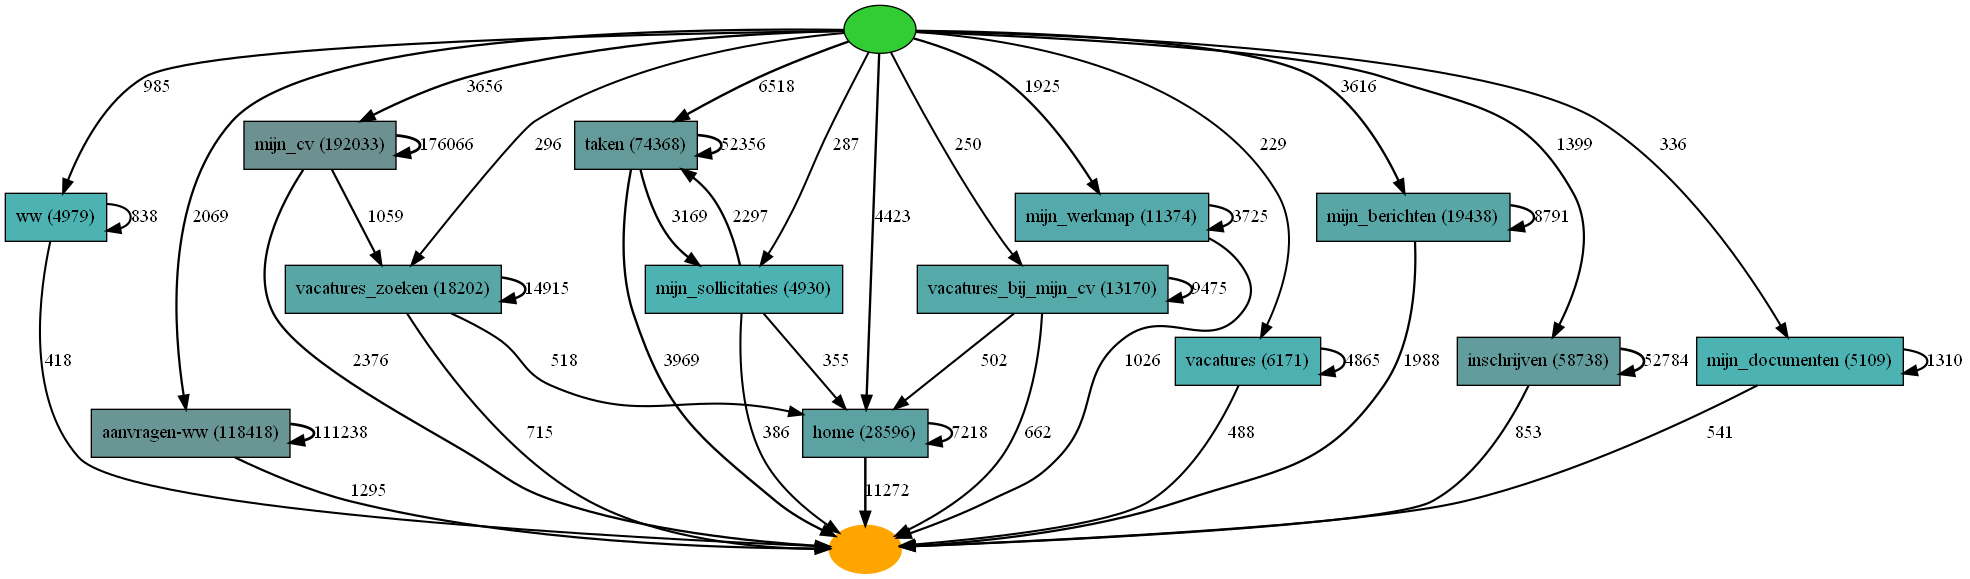

In [336]:
# Simplified Interface
heu_net = pm4py.discover_heuristics_net(
    log_first_sessions, dependency_threshold=0.997, 
    and_threshold=0.999, 
    loop_two_threshold=0.999
)
pm4py.save_vis_heuristics_net(heu_net, file_path='log_first_sessions-heuristics_net.png') 
pm4py.view_heuristics_net(heu_net)

In [264]:
Fifitinth_sessions_of_customers_log = clicks_logged_in_SelectedColumns[clicks_logged_in_SelectedColumns['SessionID'].isin(Sessions['15 Sessions'])]